### Deep Style - Demo_2

This is the demonstration for our project that implements Neural Style Transfer from two papers, along with some modifications suggested. The first demo file Deep Style - Demo_1 consists of the demonstration for the Gatys implementation

The below cells give a demo for the second implementation of our project: Real Time Style Transfer with Instance Normalization and Upsampling Convolution Layers

Style Image: Starry Night
Content Image: amber.jpg and autumn.jpg

In [1]:
import os
import sys
import time
import re
import pickle
import torchvision as tv
import numpy as np
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import torch.onnx
from matplotlib import pyplot as plt
import utils
from vgg import Vgg16
import nntools as nt
from torch import nn
import torchvision.models as models

In [2]:
class transformation_net_batch(torch.nn.Module):
    def __init__(self):
        super(transformation_net_batch, self).__init__()
        
        # Initial Downsampling layers

        self.conv1 = Conv_Layer(3, 32, 9, stride=1)
        self.bn1 = torch.nn.BatchNorm2d(32, affine=True)

        self.conv2 = Conv_Layer(32, 64, 3, stride=2)
        self.bn2 = torch.nn.BatchNorm2d(64, affine=True)

        self.conv3 = Conv_Layer(64, 128, 3, stride=2)
        self.bn3 = torch.nn.BatchNorm2d(128, affine=True)

        # Residual layers
        self.res1 = Res_block_Batch(128)
        self.res2 = Res_block_Batch(128)
        self.res3 = Res_block_Batch(128)
        self.res4 = Res_block_Batch(128)
        self.res5 = Res_block_Batch(128)
        
        # Final Upsampling Layers
        self.deconv1 = Conv_Layer(128, 64, kernel_size=3, stride=1, upsample=2)
        self.bn4 = torch.nn.BatchNorm2d(64, affine=True)

        self.deconv2 = Conv_Layer(64, 32, kernel_size=3, stride=1, upsample=2)
        self.bn5 = torch.nn.BatchNorm2d(32, affine=True)

        self.deconv3 = Conv_Layer(32, 3, kernel_size=9, stride=1)
    
        # Residual Layers
        
        self.relu = torch.nn.ReLU()

    def forward(self, X):
        y = self.relu(self.bn1(self.conv1(X)))
        y = self.relu(self.bn2(self.conv2(y)))
        y = self.relu(self.bn3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.bn4(self.deconv1(y)))
        y = self.relu(self.bn5(self.deconv2(y)))
        y = self.deconv3(y)
        return y
    
class Res_block_Batch(torch.nn.Module):
    
    def __init__(self, channels):
        super(Res_block_Batch, self).__init__()
        self.conv1 = Conv_Layer(channels, channels, kernel_size=3, stride=1)
        self.bn1 = torch.nn.BatchNorm2d(channels, affine=True)
        self.conv2 = Conv_Layer(channels, channels, kernel_size=3, stride=1)
        self.bn2 = torch.nn.BatchNorm2d(channels, affine=True)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        h = self.relu(self.bn1(self.conv1(x)))
        h = self.bn2(self.conv2(h))
        h = h + x
        return h


In [3]:
class transformation_net_instance(torch.nn.Module):
    def __init__(self):
        super(transformation_net_instance, self).__init__()
        
        # Initial Downsampling layers

        self.conv1 = Conv_Layer(3, 32, 9, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(32, affine=True)

        self.conv2 = Conv_Layer(32, 64, 3, stride=2)
        self.in2 = torch.nn.InstanceNorm2d(64, affine=True)

        self.conv3 = Conv_Layer(64, 128, 3, stride=2)
        self.in3 = torch.nn.InstanceNorm2d(128, affine=True)

        # Residual layers
        self.res1 = Res_block_Instance(128)
        self.res2 = Res_block_Instance(128)
        self.res3 = Res_block_Instance(128)
        self.res4 = Res_block_Instance(128)
        self.res5 = Res_block_Instance(128)
        
        # Final Upsampling Layers
        self.deconv1 = Conv_Layer(128, 64, kernel_size=3, stride=1, upsample=2)
        self.in4 = torch.nn.InstanceNorm2d(64, affine=True)

        self.deconv2 = Conv_Layer(64, 32, kernel_size=3, stride=1, upsample=2)
        self.in5 = torch.nn.InstanceNorm2d(32, affine=True)

        self.deconv3 = Conv_Layer(32, 3, kernel_size=9, stride=1)
    
        # Residual Layers
        
        self.relu = torch.nn.ReLU()

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y

class Res_block_Instance(torch.nn.Module):
    
    def __init__(self, channels):
        super(Res_block_Instance, self).__init__()
        self.conv1 = Conv_Layer(channels, channels, kernel_size=3, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = Conv_Layer(channels, channels, kernel_size=3, stride=1)
        self.in2 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        h = self.relu(self.in1(self.conv1(x)))
        h = self.in2(self.conv2(h))
        h = h + x
        return h

In [4]:
class Conv_Layer(torch.nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(Conv_Layer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        h = self.reflection_pad(x_in)
        h = self.conv(h)
        return h

In [5]:
def test_stylize(args):
    device = torch.device("cuda" if args.cuda else "cpu")

    content_image = utils.imread(args.content_image, scale=args.content_scale)
    content_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.mul(255))
    ])
    content_image = content_transform(content_image)
    content_image = content_image.unsqueeze(0).to(device)

    with torch.no_grad():
        if args.Normalization == 'instance':
            style_model = transformation_net_instance()
        else:
            style_model = transformation_net_batch()
        style_model.eval()
        state_dict = torch.load(args.model)

        print ("Found the model!")
        if args.Normalization == 'instance':
            for k in list(state_dict.keys()):
                if re.search(r'in\d+\.running_(mean|var)$', k):
                    del state_dict[k]
                if re.search(r'conv\d+\.conv2d.(weight|bias)$', k):
                    k1 = k.replace("2d", "")
                    state_dict[k1] = state_dict[k]
                    del state_dict[k]

        style_model.load_state_dict(state_dict)
        style_model.to(device)
        print ("Loaded the model")

        output = style_model(content_image).cpu()

    utils.save_image(args.output_image, output[0])

    print ("Saved image")

In [6]:
class Args_eval:
    content_image = '../Realtime style transfer/Images/Content/amber.jpg'
    content_scale = None
    output_image = '../Realtime style transfer/Images/Stylized images/instancenorm-starry-amber-styled.jpg'
    model = '../Realtime style transfer/Trained models/instancenorm_starrynight_stylised.pth'
    cuda = 1
    Normalization = 'instance'
    

Found the model!
Loaded the model
Saved image


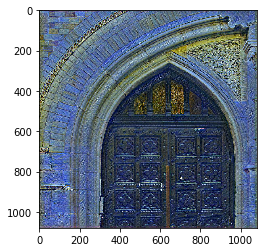

In [7]:
args=Args_eval()
test_stylize(args)
img = plt.imread(args.output_image)
plt.imshow(img)

In [9]:
class Args_eval:
    content_image = '../Realtime style transfer/Images/Content/autumn.jpg'
    content_scale = None
    output_image = '../Realtime style transfer/Images/Stylized images/instancenorm-starry-autumn-styled.jpg'
    model = '../Realtime style transfer/Trained models/instancenorm_starrynight_stylised.pth'
    cuda = 1
    Normalization = 'instance'

Found the model!
Loaded the model
Saved image


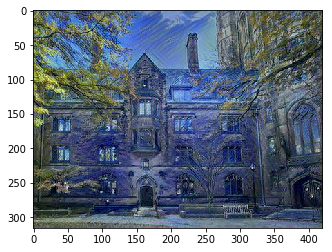

In [10]:
args=Args_eval()
test_stylize(args)
img = plt.imread(args.output_image)
plt.imshow(img)